I risultati, i modelli e i grafici verranno salvati in: 'decoder_only_results_20250912_130321'
--- Inizio Preprocessing ---
Formato data: (324, 29)
--- Preprocessing Completato ---

Scalers salvati in: 'decoder_only_results_20250912_130321/scalers.gz'

Utilizzo del dispositivo: cuda

--- FOLD FINALE 1/5 ---
  Lunghezza training data: 264, Lunghezza test data: 12
  Previsione di 12 step futuri...
Caricamento del modello migliore da 'decoder_only_results_20250912_130321/fold_1/best_decoder_model.pth' con Val Loss: 0.009814
Modello del Fold 1 salvato in 'decoder_only_results_20250912_130321/fold_1'
  MSE Fold 1: 153259632.0000
  RMSE Fold 1: 12379.8074
  MAE Fold 1: 11316.5078

--- FOLD FINALE 2/5 ---
  Lunghezza training data: 276, Lunghezza test data: 12
  Previsione di 12 step futuri...
Caricamento del modello migliore da 'decoder_only_results_20250912_130321/fold_2/best_decoder_model.pth' con Val Loss: 0.007823
Modello del Fold 2 salvato in 'decoder_only_results_20250912_130321/fold_2

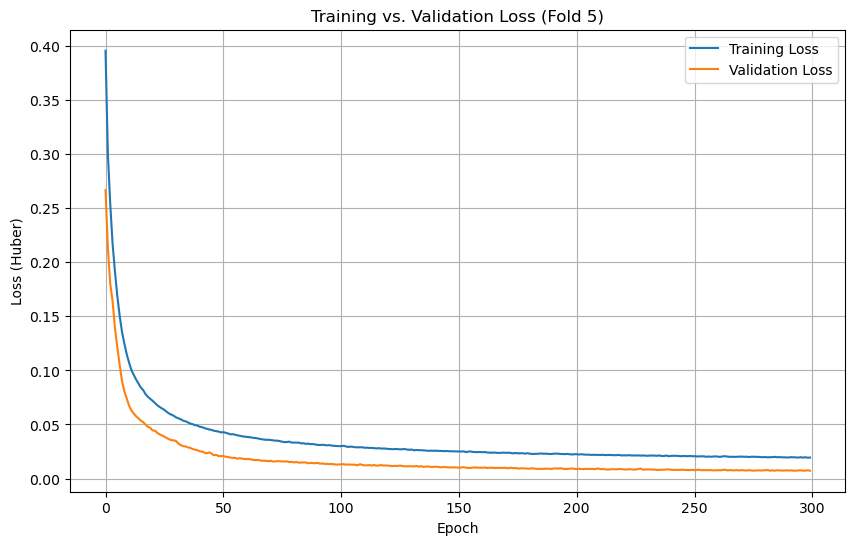


--- Risultati Finali Cross-Validation ---
  MSE Medio su tutti i fold: 271551308.8000
  RMSE Medio su tutti i fold: 16478.8139
  MAE Medio su tutti i fold: 13878.7031

Visualizzazione e salvataggio dei risultati di tutti i fold...


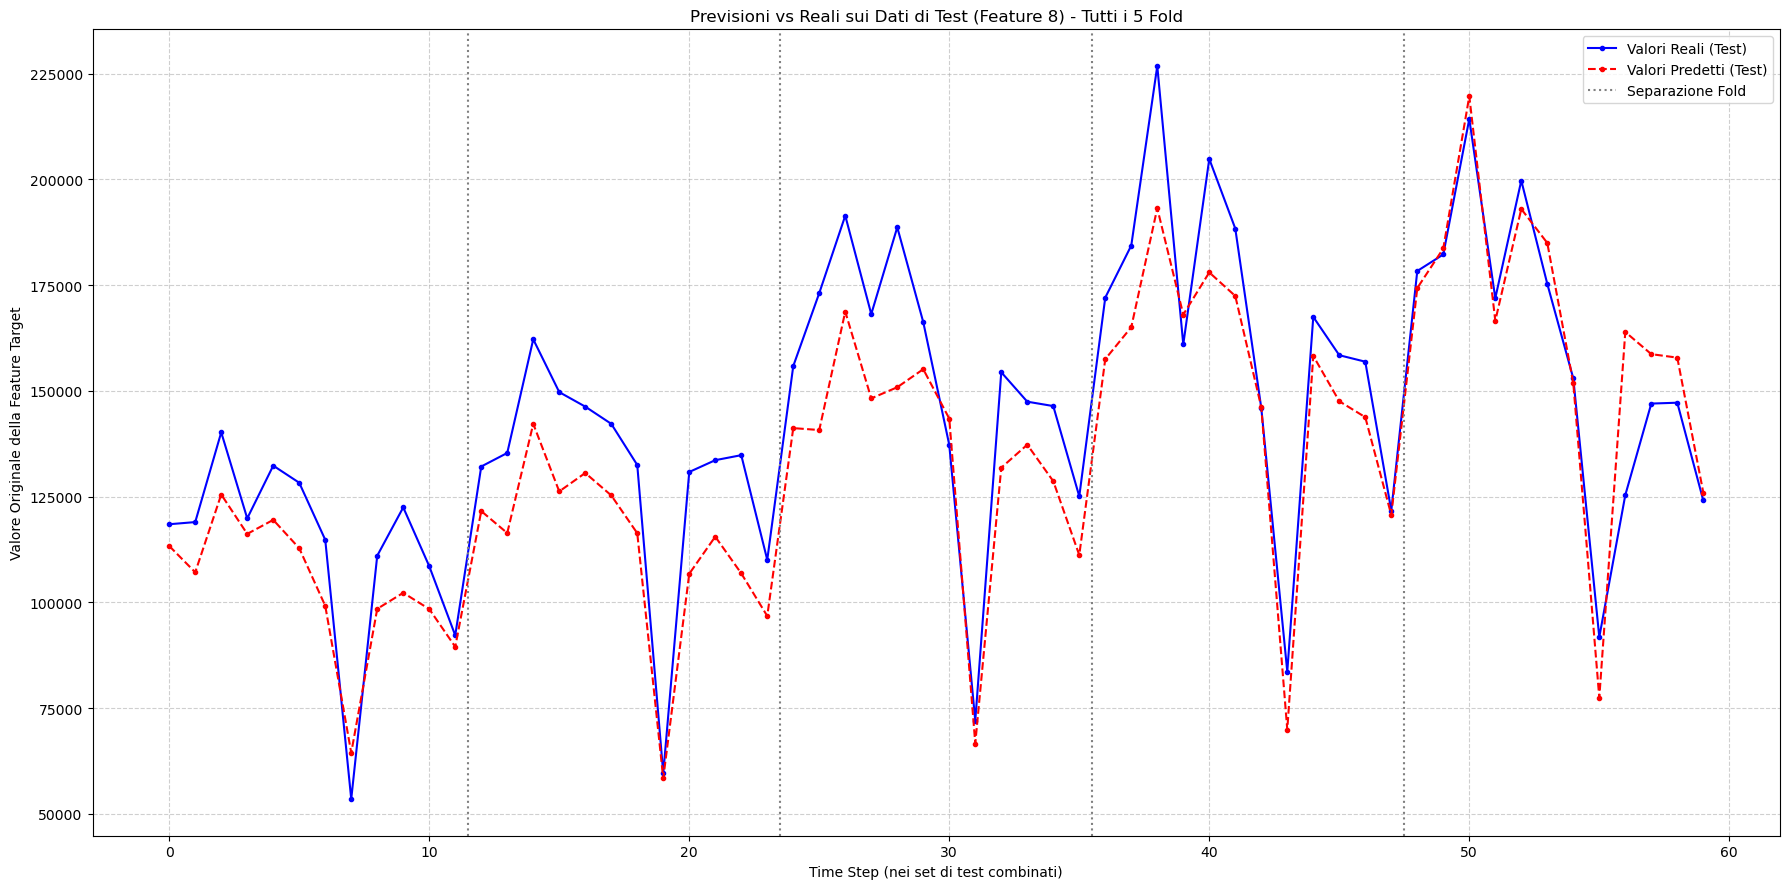


--- Analisi e Salvataggio degli Errori ---


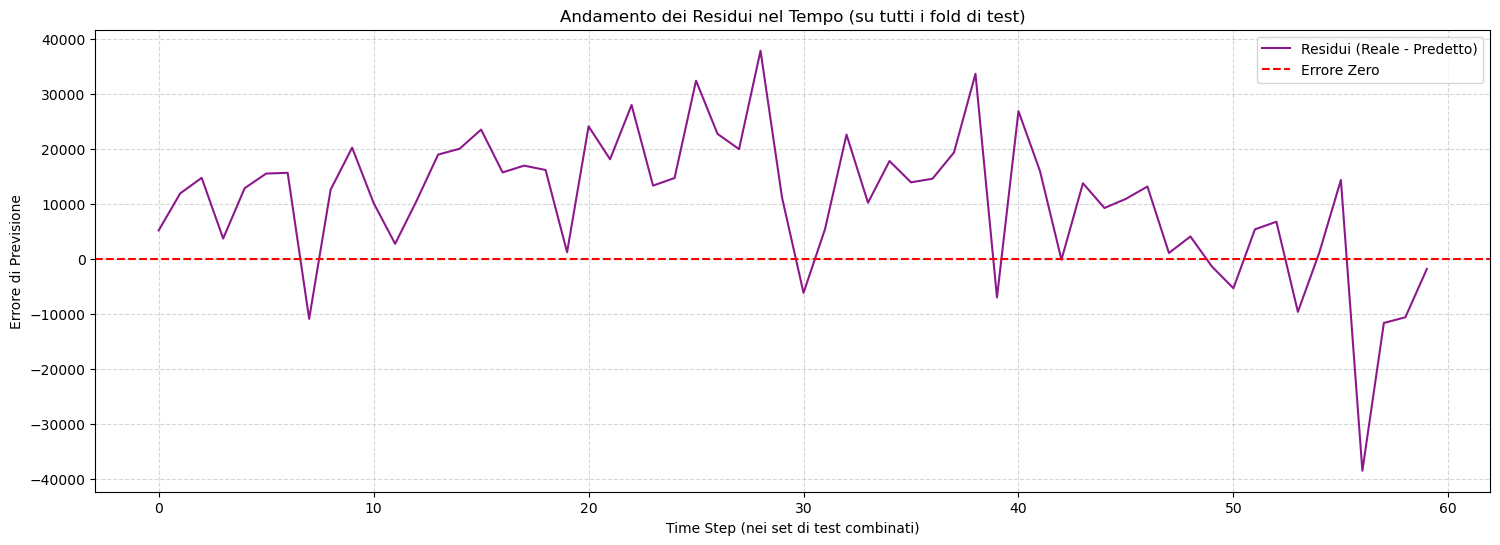

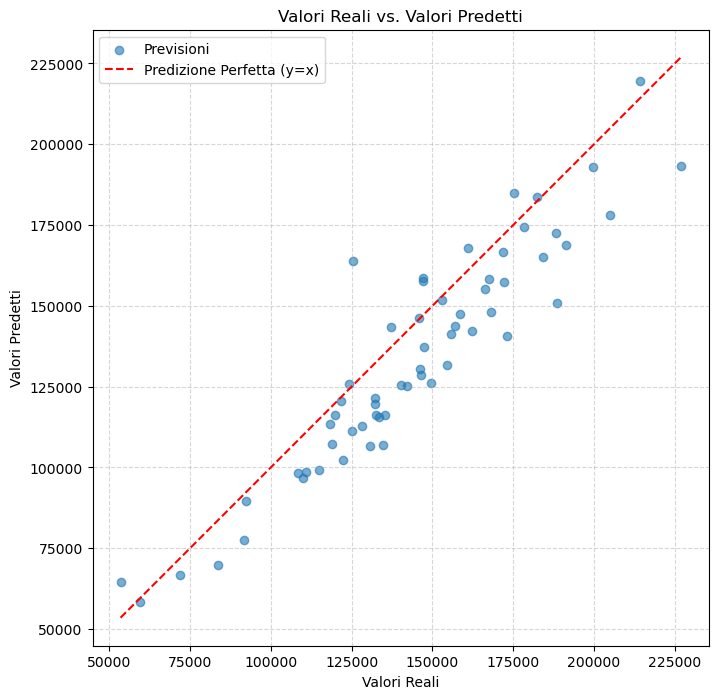

  Errore relativo medio: 9.83%

✅ Esecuzione completata. Tutti i risultati sono stati salvati in 'decoder_only_results_20250912_130321'.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import random
from datetime import datetime
import joblib


# Creo una cartella principale per questo run, basata sul timestamp corrente
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = f"decoder_only_results_{timestamp}"
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"I risultati, i modelli e i grafici verranno salvati in: '{RESULTS_DIR}'")


# 1. DEFINIZIONE DEL MODELLO
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, num_features, embed_size, num_heads, num_layers, ff_hidden_dim, dropout=0.1):
        super(DecoderOnlyTransformer, self).__init__()
        self.embed_size = embed_size
        self.input_linear = nn.Linear(num_features, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size, dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=ff_hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, num_features)

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    def forward(self, src):
        src_emb = self.input_linear(src) * math.sqrt(self.embed_size)
        src_pos = self.pos_encoder(src_emb.transpose(0, 1)).transpose(0, 1)
        tgt_mask = self.generate_square_subsequent_mask(src.size(1)).to(src.device)
        output = self.transformer_decoder(tgt=src_pos, memory=src_pos, tgt_mask=tgt_mask)
        out = self.fc_out(output)
        return out

# 2. PREPROCESSING E CREAZIONE FEATURE
def preprocess_data(file_path, target_col_name):
    print("--- Inizio Preprocessing ---")
    try:
        data_df = pd.read_csv(file_path, header=None)
        if not isinstance(target_col_name, int):
            raise ValueError("target_col_name must be an integer index.")
        data_df = data_df.astype(np.float32)
    except FileNotFoundError:
        print(f"ERRORE: File '{file_path}' non trovato.")
        return None, None, None, None, None

    data_log = np.log1p(data_df)
    start_date = pd.to_datetime("1990-01-01")
    dates = pd.date_range(start_date, periods=len(data_df), freq='MS')
    data_log['year'] = dates.year
    data_log['month_sin'] = np.sin(2 * np.pi * dates.month / 12.0)
    data_log['month_cos'] = np.cos(2 * np.pi * dates.month / 12.0)
    data_log[f'{target_col_name}_lag_1'] = data_log[target_col_name].shift(1)
    data_log[f'{target_col_name}_lag_12'] = data_log[target_col_name].shift(12)
    data_log[f'{target_col_name}_lag_24'] = data_log[target_col_name].shift(24)
    data_log[f'{target_col_name}_rolling_mean_12'] = data_log[target_col_name].rolling(window=12).mean()
    data_log[f'{target_col_name}_rolling_std_12'] = data_log[target_col_name].rolling(window=12).std()
    data_log[f'{target_col_name}_ewma_12'] = data_log[target_col_name].ewm(span=12, adjust=False).mean()
    data_log[f'{target_col_name}_diff_1'] = data_log[target_col_name].diff(1)
    data_log[f'{target_col_name}_seasonal_diff_12'] = data_log[target_col_name].diff(12)
    data_log[f'{target_col_name}_rolling_std_3'] = data_log[target_col_name].rolling(window=3).std()
    data_log[f'{target_col_name}_rolling_std_6'] = data_log[target_col_name].rolling(window=6).std()
    
    data_log = data_log.dropna().reset_index(drop=True)
    
    print(f"Formato data: {data_log.shape}")
    values = data_log.values.astype('float32')
    N_FEATURES = values.shape[1]
    
    scalers = {}
    scaled_columns = []
    for i in range(N_FEATURES):
        scaler = StandardScaler()
        col_scaled = scaler.fit_transform(values[:, i].reshape(-1, 1))
        scalers[i] = scaler
        scaled_columns.append(col_scaled)
    scaled_values = np.hstack(scaled_columns)
    
    TARGET_COL_INDEX = target_col_name
    print("--- Preprocessing Completato ---\n")
    return scaled_values, scalers, N_FEATURES, TARGET_COL_INDEX

def create_autoregressive_sequences(data, seq_length):
    X, y = [], []
    if len(data) <= seq_length:
        return np.array(X), np.array(y)
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+1:i+seq_length+1, :])
    return np.array(X), np.array(y)

# 3. FUNZIONE DI TRAINING
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, device, num_epochs, patience, fold_dir):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = os.path.join(fold_dir, 'best_decoder_model.pth')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for seq_batch, target_batch in train_loader:
            seq_batch, target_batch = seq_batch.to(device), target_batch.to(device)
            optimizer.zero_grad()
            output = model(seq_batch)
            loss = criterion(output, target_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for seq_batch, target_batch in val_loader:
                seq_batch, target_batch = seq_batch.to(device), target_batch.to(device)
                output = model(seq_batch)
                val_loss = criterion(output, target_batch)
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        else:
            scheduler.step()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"--- Early stopping at epoch {epoch+1} ---")
            break
    
    print(f"Caricamento del modello migliore da '{best_model_path}' con Val Loss: {best_val_loss:.6f}")
    model.load_state_dict(torch.load(best_model_path))
    return history

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 4. SCRIPT PRINCIPALE
if __name__ == '__main__':
    # IPERPARAMETRI
    set_seed(42)
    SEQ_LENGTH = 24
    EMBED_SIZE = 32
    NUM_HEADS = 2
    NUM_LAYERS = 2
    FF_HIDDEN_DIM = 128
    DROPOUT = 0.1036
    BATCH_SIZE = 16
    LEARNING_RATE = 0.00099
    WEIGHT_DECAY = 2.223e-05
    
    N_SPLITS_FINAL = 5
    NUM_EPOCHS = 300
    PATIENCE = 50
    HORIZON = 12 
    FILE_PATH = "testDati.csv"
    TARGET_COL_NAME_IN_DF = 8 

    # PREPARAZIONE DATI 
    scaled_values, scalers, N_FEATURES, TARGET_COL_INDEX = preprocess_data(FILE_PATH, TARGET_COL_NAME_IN_DF)
    
    # Salva gli scaler
    if scalers:
        joblib.dump(scalers, os.path.join(RESULTS_DIR, 'scalers.gz'))
        print(f"Scalers salvati in: '{os.path.join(RESULTS_DIR, 'scalers.gz')}'")

    if scaled_values is not None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"\nUtilizzo del dispositivo: {device}")
        criterion = nn.HuberLoss() 

        tscv_final = TimeSeriesSplit(n_splits=N_SPLITS_FINAL, test_size=HORIZON)
        all_y_test_rescaled, all_y_pred_rescaled = [], []
        mse_scores_rescaled, mae_scores_rescaled = [], []

        for fold_counter, (train_index, test_index) in enumerate(tscv_final.split(scaled_values)):
            fold_num = fold_counter + 1
            print(f"\n--- FOLD FINALE {fold_num}/{N_SPLITS_FINAL} ---")

            # Crea una sottocartella per il fold
            fold_dir = os.path.join(RESULTS_DIR, f"fold_{fold_num}")
            os.makedirs(fold_dir, exist_ok=True)
            
            train_data = scaled_values[train_index]
            test_data = scaled_values[test_index]
            
            X_train, y_train = create_autoregressive_sequences(train_data, SEQ_LENGTH)
            
            if len(X_train) == 0:
                print(f"Fold {fold_num} saltato: dati di training insufficienti.")
                continue

            print(f"  Lunghezza training data: {len(train_data)}, Lunghezza test data: {len(test_data)}")
            print(f"  Previsione di {len(test_data)} step futuri...")

            train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            
            X_val, y_val = create_autoregressive_sequences(train_data[-len(test_data)-SEQ_LENGTH:], SEQ_LENGTH)
            if len(X_val) > 0:
                val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
                val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
            else: # Fallback per fold piccoli
                val_loader = DataLoader(TensorDataset(X_train[-1:], y_train[-1:]), batch_size=1)

            model = DecoderOnlyTransformer(
                num_features=N_FEATURES, embed_size=EMBED_SIZE, num_heads=NUM_HEADS,
                num_layers=NUM_LAYERS, ff_hidden_dim=FF_HIDDEN_DIM, dropout=DROPOUT
            ).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=PATIENCE//2, factor=0.5)

            history = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, device, NUM_EPOCHS, PATIENCE, fold_dir)
            print(f"Modello del Fold {fold_num} salvato in '{fold_dir}'")
            
            # Salva la history del training
            pd.DataFrame(history).to_csv(os.path.join(fold_dir, 'training_history.csv'), index=False)
            
            
            model.eval()
            predictions_fold_scaled = []
            current_context_np = train_data[-SEQ_LENGTH:]
            
            with torch.no_grad():
                for i in range(HORIZON):
                    context_tensor = torch.FloatTensor(current_context_np).unsqueeze(0).to(device)
                    output = model(context_tensor)
                    next_predicted_features_scaled = output[0, -1, :].cpu().numpy()
                    predicted_target_value = next_predicted_features_scaled[TARGET_COL_INDEX]
                    predictions_fold_scaled.append(predicted_target_value)
                    current_context_np = np.vstack([current_context_np[1:], next_predicted_features_scaled])

            target_scaler = scalers[TARGET_COL_INDEX]
            y_test_fold_scaled = test_data[:, TARGET_COL_INDEX]
            y_test_denorm = target_scaler.inverse_transform(y_test_fold_scaled.reshape(-1, 1))
            y_test_final = np.expm1(y_test_denorm).flatten()
            
            y_pred_denorm = target_scaler.inverse_transform(np.array(predictions_fold_scaled).reshape(-1, 1))
            y_pred_final = np.expm1(y_pred_denorm).flatten()

            # Salva le predizioni del fold
            pd.DataFrame({
                'y_test_final': y_test_final,
                'y_pred_final': y_pred_final
            }).to_csv(os.path.join(fold_dir, 'predictions.csv'), index=False)

            all_y_pred_rescaled.append(y_pred_final)
            all_y_test_rescaled.append(y_test_final)
            
            mse_fold = mean_squared_error(y_test_final, y_pred_final)
            mae_fold = mean_absolute_error(y_test_final, y_pred_final)
            mse_scores_rescaled.append(mse_fold)
            mae_scores_rescaled.append(mae_fold)
            print(f"  MSE Fold {fold_num}: {mse_fold:.4f}")
            print(f"  RMSE Fold {fold_num}: {np.sqrt(mse_fold):.4f}")
            print(f"  MAE Fold {fold_num}: {mae_fold:.4f}")
            
            if fold_num == N_SPLITS_FINAL:
                plt.figure(figsize=(10, 6))
                plt.plot(history['train_loss'], label='Training Loss')
                plt.plot(history['val_loss'], label='Validation Loss')
                plt.title(f'Training vs. Validation Loss (Fold {fold_num})')
                plt.xlabel('Epoch')
                plt.ylabel('Loss (Huber)')
                plt.legend()
                plt.grid(True)
                plt.savefig(os.path.join(RESULTS_DIR, f'loss_plot_fold_{fold_num}.png'))
                plt.show()

        # 5. RISULTATI FINALI E VISUALIZZAZIONE
        y_true_combined = np.concatenate(all_y_test_rescaled)
        y_pred_combined = np.concatenate(all_y_pred_rescaled)
        
        final_mse = np.mean(mse_scores_rescaled)
        final_rmse = np.sqrt(final_mse)
        final_mae = np.mean(mae_scores_rescaled)
        
        print("\n--- Risultati Finali Cross-Validation ---")
        print(f"  MSE Medio su tutti i fold: {final_mse:.4f}")
        print(f"  RMSE Medio su tutti i fold: {final_rmse:.4f}")
        print(f"  MAE Medio su tutti i fold: {final_mae:.4f}")

        # Salva un riepilogo delle metriche
        with open(os.path.join(RESULTS_DIR, 'summary_metrics.txt'), 'w') as f:
            f.write("--- Risultati Finali della Cross-Validation ---\n")
            f.write(f"MSE Medio (dai fold): {final_mse:.4f}\n")
            f.write(f"RMSE Medio (dai fold): {final_rmse:.4f}\n")
            f.write(f"MAE Medio (dai fold): {final_mae:.4f}\n")

        print("\nVisualizzazione e salvataggio dei risultati di tutti i fold...")
        plt.figure(figsize=(18, 9))
        prediction_indices = np.arange(len(y_true_combined))
        
        plt.plot(prediction_indices, y_true_combined, label='Valori Reali (Test)', color='blue', marker='o', linestyle='-', markersize=3)
        plt.plot(prediction_indices, y_pred_combined, label='Valori Predetti (Test)', color='red', marker='o', linestyle='--',  markersize=3)
        
        for i in range(N_SPLITS_FINAL - 1):
            vline_pos = (i + 1) * HORIZON - 0.5
            plt.axvline(x=vline_pos, color='gray', linestyle=':', label=f'Separazione Fold' if i == 0 else "")
        
        plt.title(f"Previsioni vs Reali sui Dati di Test (Feature {TARGET_COL_INDEX}) - Tutti i {N_SPLITS_FINAL} Fold")
        plt.xlabel("Time Step (nei set di test combinati)")
        plt.ylabel("Valore Originale della Feature Target")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'combined_predictions_plot.png'))
        plt.show()
        
        # 6. ANALISI DEGLI ERRORI
        print("\n--- Analisi e Salvataggio degli Errori ---")
        if len(y_true_combined) > 0 and len(y_pred_combined) > 0:
            residuals = y_true_combined - y_pred_combined

            plt.figure(figsize=(18, 6))
            plt.plot(residuals, label='Residui (Reale - Predetto)', color='purple', alpha=0.9)
            plt.axhline(0, color='red', linestyle='--', label='Errore Zero')
            plt.title('Andamento dei Residui nel Tempo (su tutti i fold di test)')
            plt.xlabel('Time Step (nei set di test combinati)')
            plt.ylabel('Errore di Previsione')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.savefig(os.path.join(RESULTS_DIR, 'residuals_plot.png'))
            plt.show()

            plt.figure(figsize=(8, 8))
            plt.scatter(y_true_combined, y_pred_combined, alpha=0.6, label='Previsioni')
            perfect_line = np.linspace(min(y_true_combined), max(y_true_combined), 100)
            plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Predizione Perfetta (y=x)')
            plt.title('Valori Reali vs. Valori Predetti')
            plt.xlabel('Valori Reali')
            plt.ylabel('Valori Predetti')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.axis('equal')
            plt.gca().set_aspect('equal', adjustable='box')
            plt.savefig(os.path.join(RESULTS_DIR, 'scatter_plot_real_vs_pred.png'))
            plt.show()
            
            epsilon = 1e-9
            y_true_safe = np.where(y_true_combined == 0, epsilon, y_true_combined)
            relative_errors = np.abs(residuals) / y_true_safe
            mean_relative_error = np.mean(relative_errors) * 100
            print(f"  Errore relativo medio: {mean_relative_error:.2f}%")
            with open(os.path.join(RESULTS_DIR, 'summary_metrics.txt'), 'a') as f:
                f.write(f"Errore relativo medio: {mean_relative_error:.2f}%\n")
        else:
            print("Nessun risultato di test da analizzare.")
        
        print(f"\n✅ Esecuzione completata. Tutti i risultati sono stati salvati in '{RESULTS_DIR}'.")

